Import Liabraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge


from numpy.random import seed
seed(69)

Exploring the Data




In [3]:
data = pd.read_csv('AAPL.csv')

In [ ]:
data.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098578,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103376,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.107739,46950400
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.113409,48003200
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.123877,55574400


In [4]:
data['Date'] = pd.to_datetime(data['Date'])


In [5]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['Open Price Change'] = data['Open'].diff()

In [6]:
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,year,month,Open Price Change
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600,1980,12,NaN
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800,1980,12,-0.006138
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000,1980,12,-0.008929
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600,1980,12,0.002232
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600,1980,12,0.003349


Text(0.5, 1.0, 'Volume trend over time')

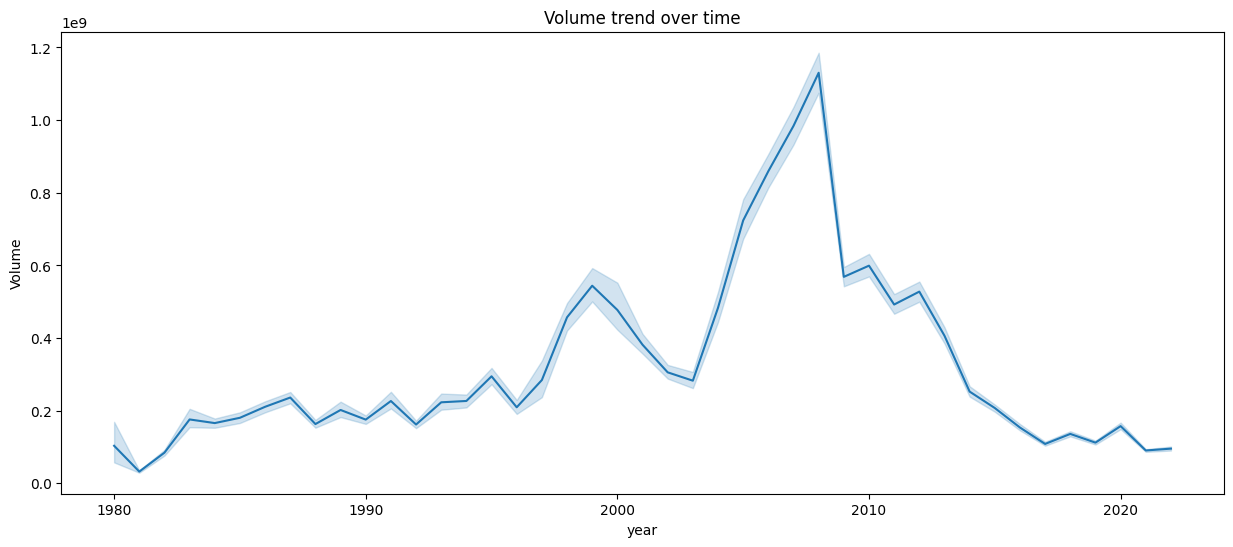

In [7]:
plt.figure(figsize=(15, 6))
sns.lineplot(y = data['Volume'], x= data['year'])
plt.title("Volume trend over time")

Text(0.5, 1.0, 'Adj Close trend over time')

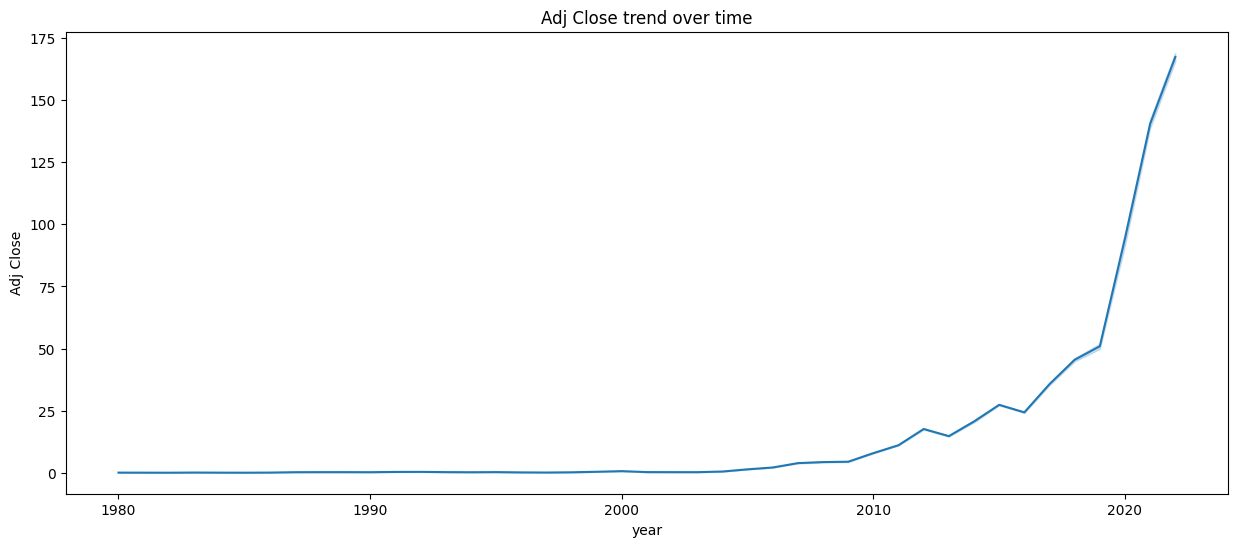

In [8]:
plt.figure(figsize=(15, 6))
sns.lineplot(y = data['Adj Close'], x= data['year'])
plt.title("Adj Close trend over time")

In [9]:
open_price = go.Waterfall(x = data['Date'], y = data['Open Price Change'],
                         decreasing = {'marker': {'color': 'red'}},
                          increasing = {'marker': {'color': 'green'}})

layout = go.Layout(title = 'Apple Open Price Change Waterfall',
                  xaxis = dict(title = 'Date'), yaxis = dict(title = 'Open Price Change'),
                  xaxis_tickangle = 45)

fig = go.Figure(data = [open_price], layout = layout)
fig.show()

Predicting Opening Value



Preparing Train Data

In [10]:
df_apple = pd.read_csv("AAPL.csv")
df_apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [11]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'], format="%Y-%m-%d")


In [12]:
open_price=df_apple.loc[:,'Open'].to_numpy()


In [13]:
open_price = open_price.reshape(-1, 1)
train_set = open_price[:7000]
valid_set = open_price[7000:8000]
test_set = open_price[8000:]

In [14]:
sc = MinMaxScaler(feature_range=(0, 1))
sc_valid = MinMaxScaler(feature_range=(0, 1))
sc_test = MinMaxScaler(feature_range=(0, 1))

train_set_scaled = sc.fit_transform(train_set)
valid_set_scaled = sc_valid.fit_transform(valid_set)
test_set_scaled = sc_test.fit_transform(test_set)

In [15]:
def generate_data(data, window_size_input = 300):
    X = []
    y = []
    for i in range(window_size_input, len(data)):
        # Get the data
        X_data = data[i - window_size_input : i, 0]
        y_data = data[i, 0]
        X.append(X_data)
        y.append(y_data)
    return np.array(X), np.array(y)

In [16]:
WINDOW_SIZE_SEARCH = 300

X_train, y_train = generate_data(train_set_scaled, WINDOW_SIZE_SEARCH)
X_valid, y_valid = generate_data(valid_set_scaled, WINDOW_SIZE_SEARCH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

Making Model



In [17]:
model_1_open = Sequential()

model_1_open.add(LSTM(256, return_sequences=False, input_shape= (X_train.shape[1], 1)))
model_1_open.add(Dense(128))
model_1_open.add(Dense(64))
model_1_open.add(Dense(1))

model_1_open.compile(optimizer = 'adam', loss = 'mean_squared_error',)

In [18]:
hist = model_1_open.fit(X_train, y_train, epochs = 10, batch_size = 64, verbose = 2)


Epoch 1/10
105/105 - 129s - loss: 0.0012 - 129s/epoch - 1s/step
Epoch 2/10
105/105 - 126s - loss: 8.0219e-05 - 126s/epoch - 1s/step
Epoch 3/10
105/105 - 128s - loss: 7.2577e-05 - 128s/epoch - 1s/step
Epoch 4/10
105/105 - 124s - loss: 7.7323e-05 - 124s/epoch - 1s/step
Epoch 5/10
105/105 - 126s - loss: 6.5894e-05 - 126s/epoch - 1s/step
Epoch 6/10
105/105 - 126s - loss: 9.6839e-05 - 126s/epoch - 1s/step
Epoch 7/10
105/105 - 126s - loss: 7.4080e-05 - 126s/epoch - 1s/step
Epoch 8/10
105/105 - 126s - loss: 6.3772e-05 - 126s/epoch - 1s/step
Epoch 9/10
105/105 - 124s - loss: 7.1945e-05 - 124s/epoch - 1s/step
Epoch 10/10
105/105 - 127s - loss: 5.5334e-05 - 127s/epoch - 1s/step


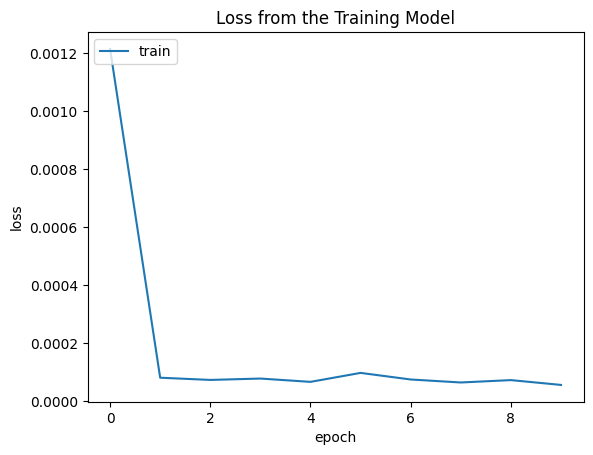

In [19]:
plt.plot(hist.history['loss'])
plt.title('Loss from the Training Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [20]:
pred_price_train=model_1_open.predict(X_train)

210/210 [==============================] - 72s 340ms/step


In [21]:
y_train=y_train.reshape(len(y_train),1)

In [22]:
y_2_train=y_train-pred_price_train

In [23]:
model_2_open=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_2_open.fit(X_train,y_2_train)
y_2_pred=model_2_open.predict(X_train)
pred_price_train+=y_2_pred


In [24]:
y_4_train=y_train-pred_price_train

In [25]:
model_4_open=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_4_open.fit(X_train,y_4_train)
y_4_pred=model_4_open.predict(X_train)
pred_price_train+=y_4_pred

In [26]:
print(mean_squared_error(pred_price_train,y_train))

3.0293290819463115e-05


Preparing Validation Data

In [27]:
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1],1))
price_prediction = model_1_open.predict(X_valid)
price_prediction_valid = sc_valid.inverse_transform(price_prediction)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1]))
y_2_valid=model_2_open.predict(X_valid)
y_4_valid=model_4_open.predict(X_valid)
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction = np.concatenate((zeros, price_prediction_valid), axis=None)

22/22 [==============================] - 5s 230ms/step


In [28]:
price_error = mean_squared_error(valid_set, price_prediction)
print("Price error on the validation set : ", price_error)

Price error on the validation set :  7.092684798231561


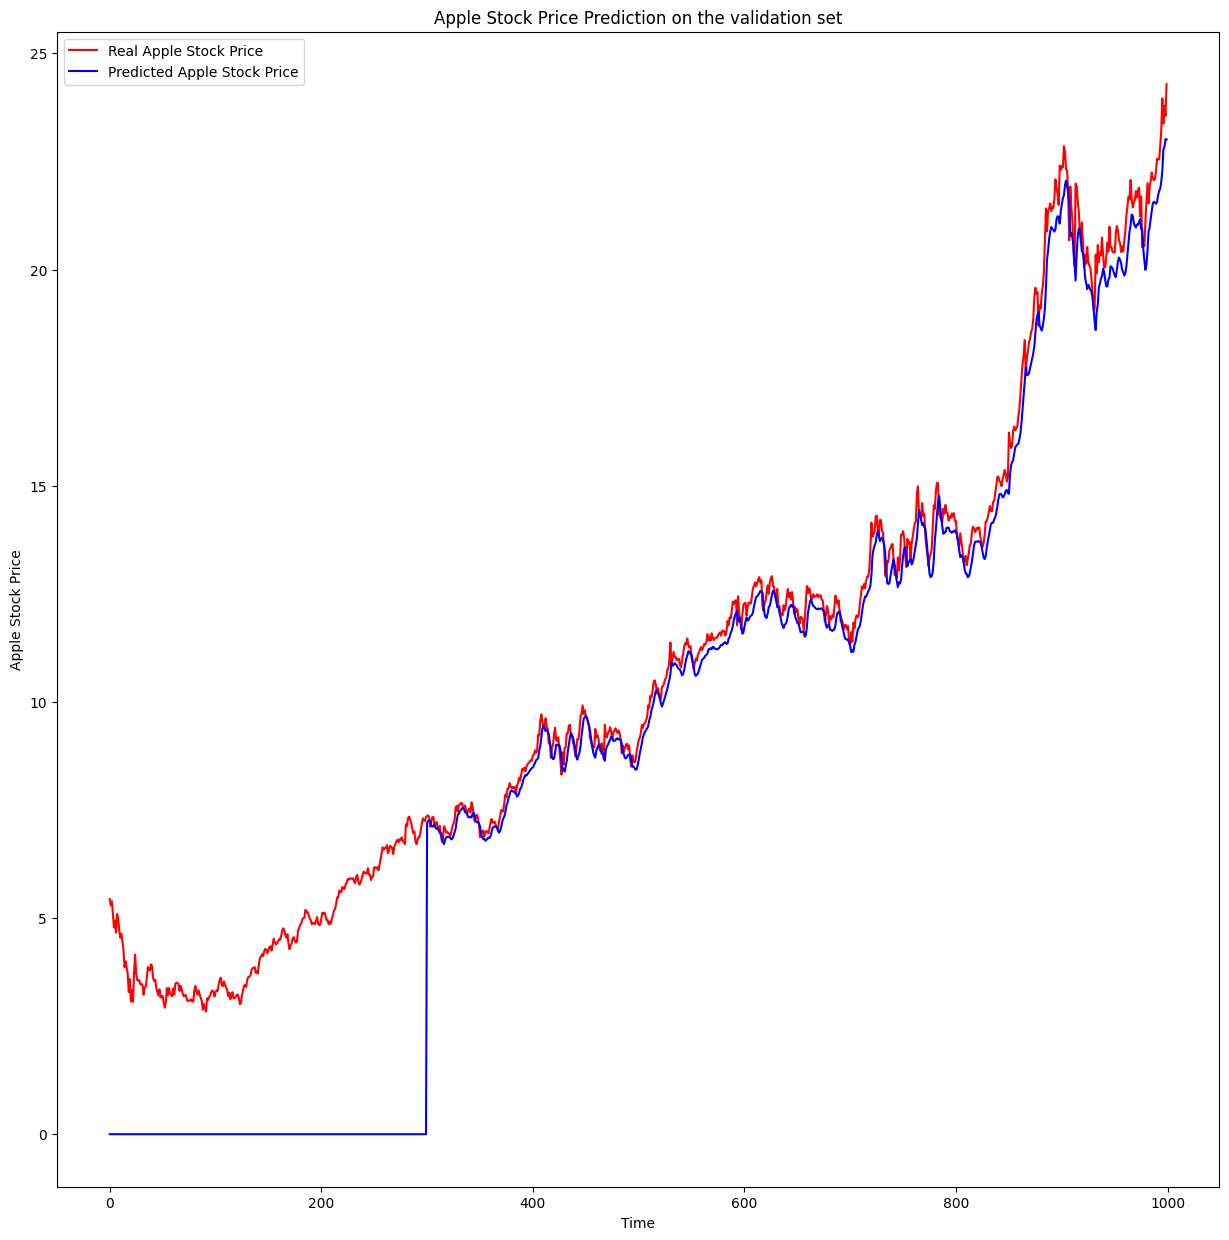

In [29]:
plt.figure(figsize=(15,15))
plt.plot(valid_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the validation set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()


Preparing Test Data

In [30]:
X_test, y_test = generate_data(test_set_scaled, WINDOW_SIZE_SEARCH)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
price_prediction_test = model_1_open.predict(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
price_error = mean_squared_error(y_test, price_prediction_test)
print("Price error on the test set : ", price_error)
y_2_test=model_2_open.predict(X_test)
y_4_test=model_4_open.predict(X_test)
price_prediction_test = sc_test.inverse_transform(price_prediction_test)

66/66 [==============================] - 18s 269ms/step
Price error on the test set :  0.0002575534261877993


In [31]:
price_error = mean_squared_error(test_set[WINDOW_SIZE_SEARCH:], price_prediction_test)
print("Price error on the test set : ", price_error)

Price error on the test set :  7.336312350590715


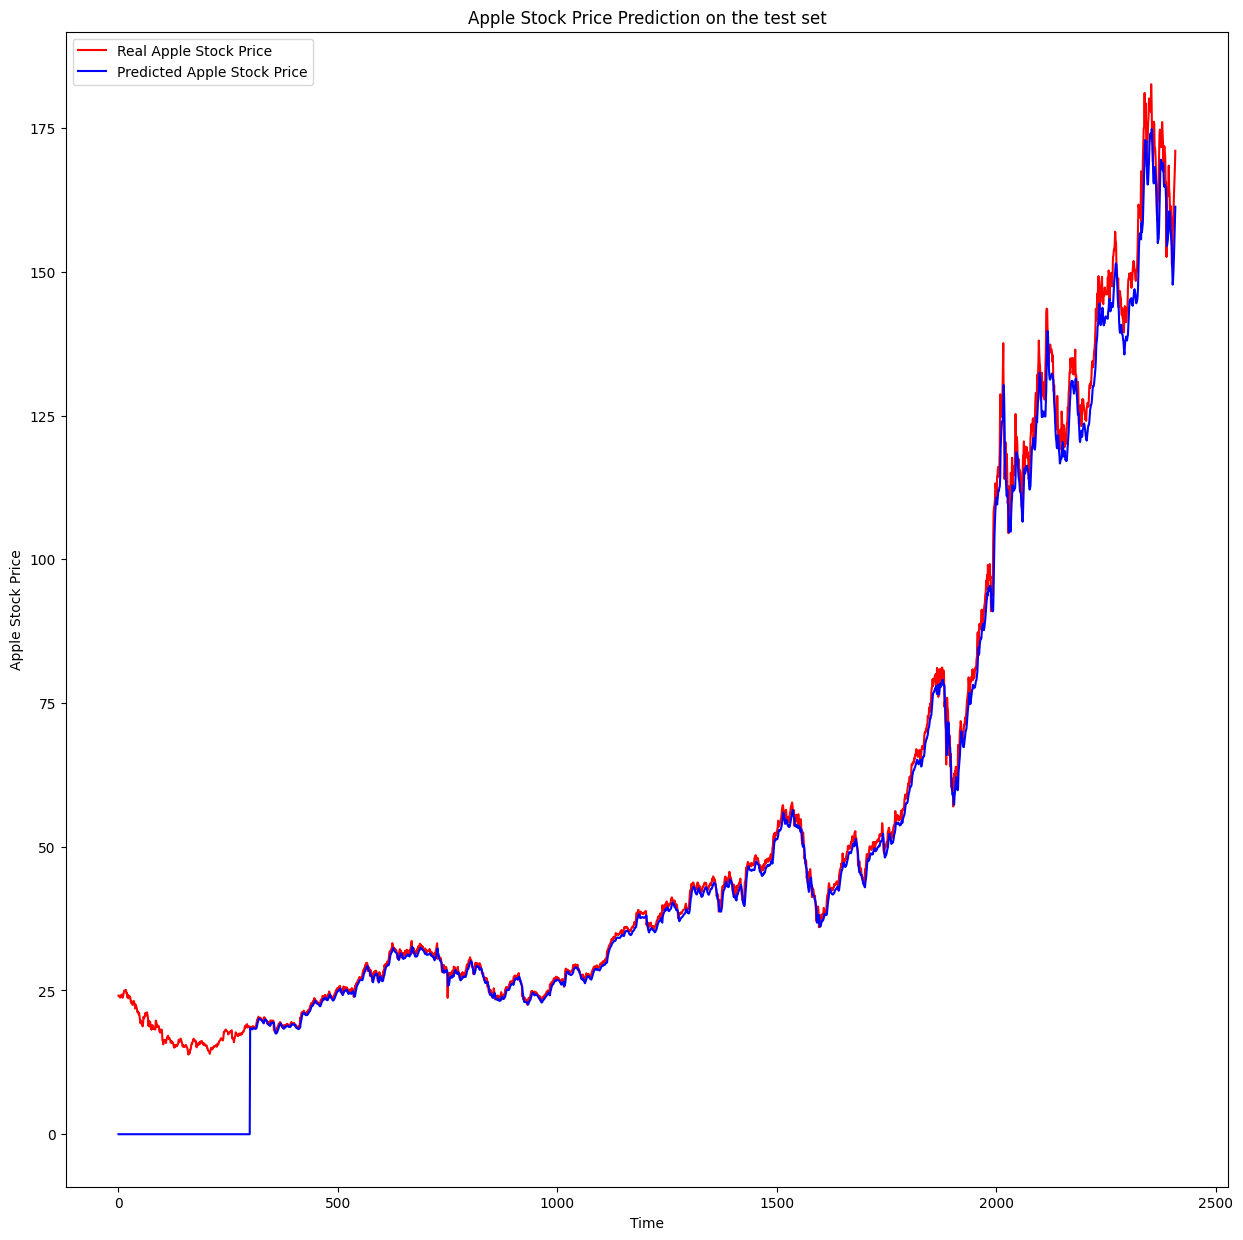

In [32]:
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction_test = np.concatenate((zeros, price_prediction_test), axis=None)
plt.figure(figsize=(15,15))
plt.plot(test_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction_test, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the test set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

Predicting Closing Value

Preparing Train Data

In [33]:
df_apple = pd.read_csv("AAPL.csv")
df_apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [34]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'], format="%Y-%m-%d")

In [35]:
close_price=df_apple.loc[:,'Close'].to_numpy()

In [36]:
close_price = close_price.reshape(-1, 1)
train_set = close_price[:7000]
valid_set = close_price[7000:8000]
test_set = close_price[8000:]

In [37]:
sc = MinMaxScaler(feature_range=(0, 1))
sc_valid = MinMaxScaler(feature_range=(0, 1))
sc_test = MinMaxScaler(feature_range=(0, 1))

train_set_scaled = sc.fit_transform(train_set)
valid_set_scaled = sc_valid.fit_transform(valid_set)
test_set_scaled = sc_test.fit_transform(test_set)

In [38]:
def generate_data(data, window_size_input = 300):
    X = []
    y = []
    for i in range(window_size_input, len(data)):
        # Get the data
        X_data = data[i - window_size_input : i, 0]
        y_data = data[i, 0]
        X.append(X_data)
        y.append(y_data)
    return np.array(X), np.array(y)

In [39]:
WINDOW_SIZE_SEARCH = 300

X_train, y_train = generate_data(train_set_scaled, WINDOW_SIZE_SEARCH)
X_valid, y_valid = generate_data(valid_set_scaled, WINDOW_SIZE_SEARCH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

Making Model

In [40]:
model_1_close = Sequential()

model_1_close.add(LSTM(256, return_sequences=False, input_shape= (X_train.shape[1], 1)))
model_1_close.add(Dense(128))
model_1_close.add(Dense(64))
model_1_close.add(Dense(1))

model_1_close.compile(optimizer = 'adam', loss = 'mean_squared_error',)

In [41]:
hist = model_1_close.fit(X_train, y_train, epochs = 10, batch_size = 64, verbose = 2)


Epoch 1/10
105/105 - 125s - loss: 9.0455e-04 - 125s/epoch - 1s/step
Epoch 2/10
105/105 - 124s - loss: 7.7721e-05 - 124s/epoch - 1s/step
Epoch 3/10
105/105 - 124s - loss: 7.9267e-05 - 124s/epoch - 1s/step
Epoch 4/10
105/105 - 128s - loss: 7.2434e-05 - 128s/epoch - 1s/step
Epoch 5/10
105/105 - 125s - loss: 8.0128e-05 - 125s/epoch - 1s/step
Epoch 6/10
105/105 - 124s - loss: 7.7341e-05 - 124s/epoch - 1s/step
Epoch 7/10
105/105 - 122s - loss: 7.6627e-05 - 122s/epoch - 1s/step
Epoch 8/10
105/105 - 126s - loss: 5.7355e-05 - 126s/epoch - 1s/step
Epoch 9/10
105/105 - 124s - loss: 7.2599e-05 - 124s/epoch - 1s/step
Epoch 10/10
105/105 - 124s - loss: 5.2199e-05 - 124s/epoch - 1s/step


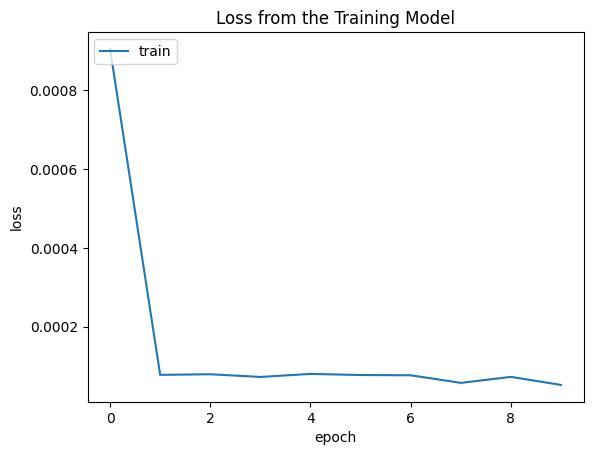

In [42]:
plt.plot(hist.history['loss'])
plt.title('Loss from the Training Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [43]:
pred_price_train=model_1_open.predict(X_train)

210/210 [==============================] - 55s 263ms/step


In [44]:
y_train=y_train.reshape(len(y_train),1)

In [45]:
y_2_train=y_train-pred_price_train

In [46]:
model_2_close=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_2_close.fit(X_train,y_2_train)
y_2_pred=model_2_close.predict(X_train)
pred_price_train+=y_2_pred

In [47]:
y_3_train=y_train-pred_price_train

In [48]:
model_3_close=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_3_close.fit(X_train,y_3_train)
y_3_pred=model_3_close.predict(X_train)
pred_price_train+=y_3_pred

In [49]:
y_4_train=y_train-pred_price_train

In [50]:
model_4_close=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_4_close.fit(X_train,y_4_train)
y_4_pred=model_4_close.predict(X_train)
pred_price_train+=y_4_pred

In [51]:
print(mean_squared_error(pred_price_train,y_train))

2.714994574710118e-05


Preparing Validation Data

In [52]:
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1],1))
price_prediction = model_1_close.predict(X_valid)
price_prediction_valid = sc_valid.inverse_transform(price_prediction)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1]))
y_2_valid=model_2_close.predict(X_valid)
y_3_valid=model_3_close.predict(X_valid)
y_4_valid=model_4_close.predict(X_valid)
price_prediction_valid+=(y_2_valid+y_3_valid+y_4_valid)
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction = np.concatenate((zeros, price_prediction_valid), axis=None)

22/22 [==============================] - 5s 230ms/step


In [53]:
price_error = mean_squared_error(valid_set, price_prediction)
print("Price error on the validation set : ", price_error)

Price error on the validation set :  6.983878615381624


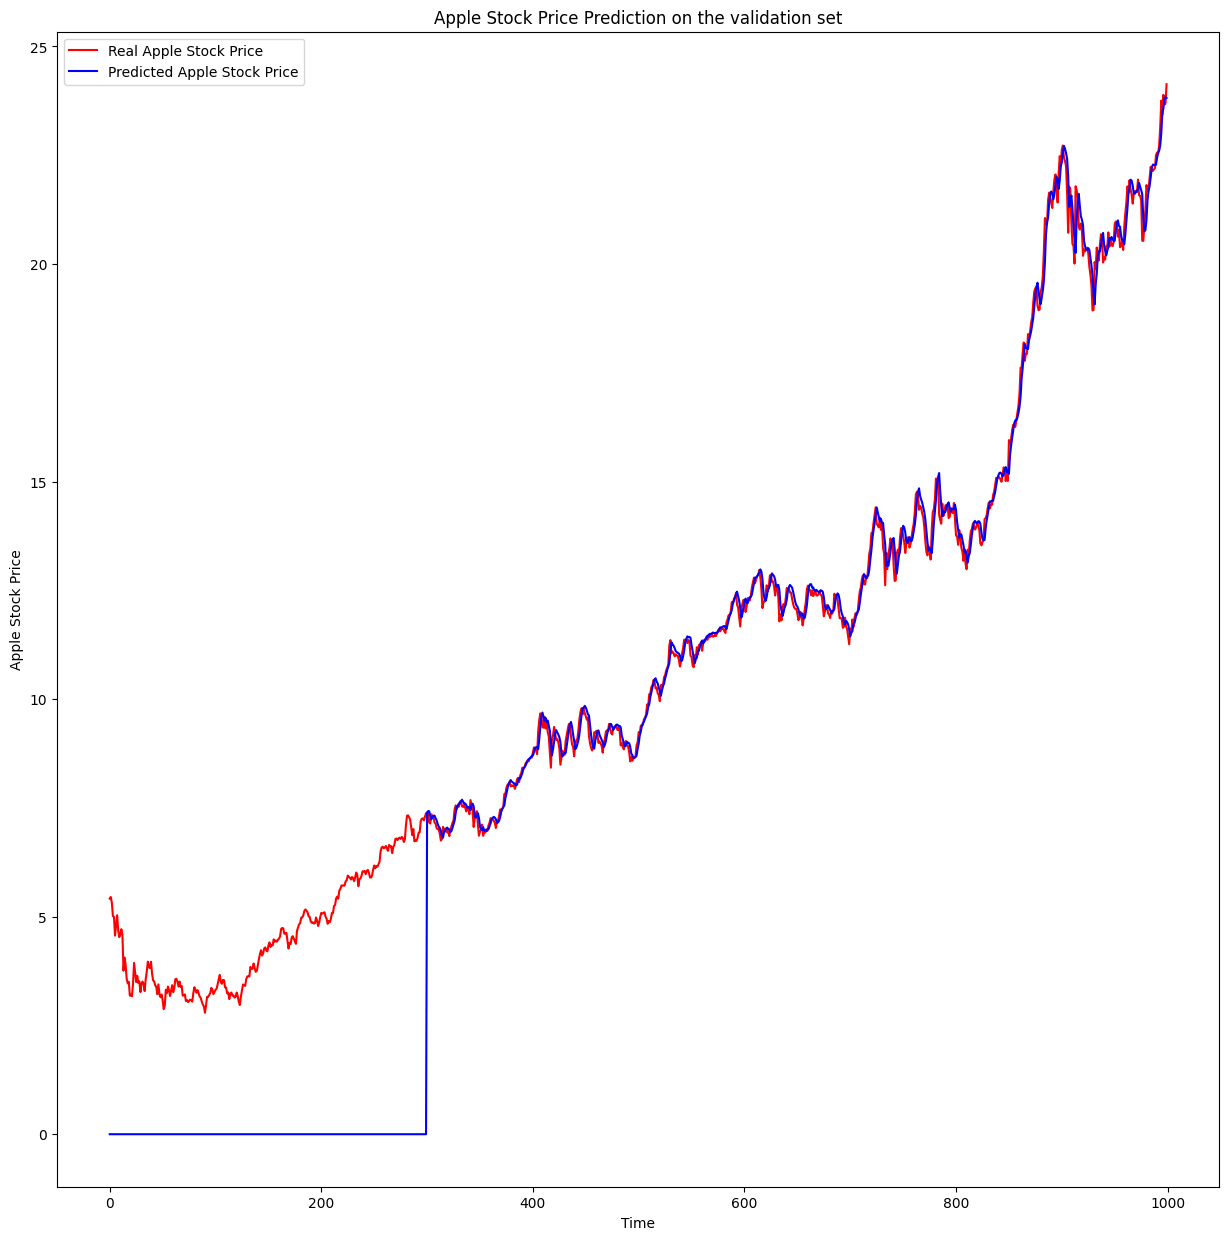

In [54]:
plt.figure(figsize=(15,15))
plt.plot(valid_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the validation set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

Preparing Test Data

In [55]:
X_test, y_test = generate_data(test_set_scaled, WINDOW_SIZE_SEARCH)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
price_prediction_test = model_1_close.predict(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
price_error = mean_squared_error(y_test, price_prediction_test)
print("Price error on the test set : ", price_error)
y_2_test=model_2_close.predict(X_test)
y_3_test=model_3_close.predict(X_test)
y_4_test=model_4_close.predict(X_test)
price_prediction_test+=(y_2_test+y_3_test+y_4_test)
price_prediction_test = sc_test.inverse_transform(price_prediction_test)

66/66 [==============================] - 18s 273ms/step
Price error on the test set :  8.483708712080317e-05


In [56]:
price_error = mean_squared_error(test_set[WINDOW_SIZE_SEARCH:], price_prediction_test)
print("Price error on the test set : ", price_error)

Price error on the test set :  7.1453041410477685


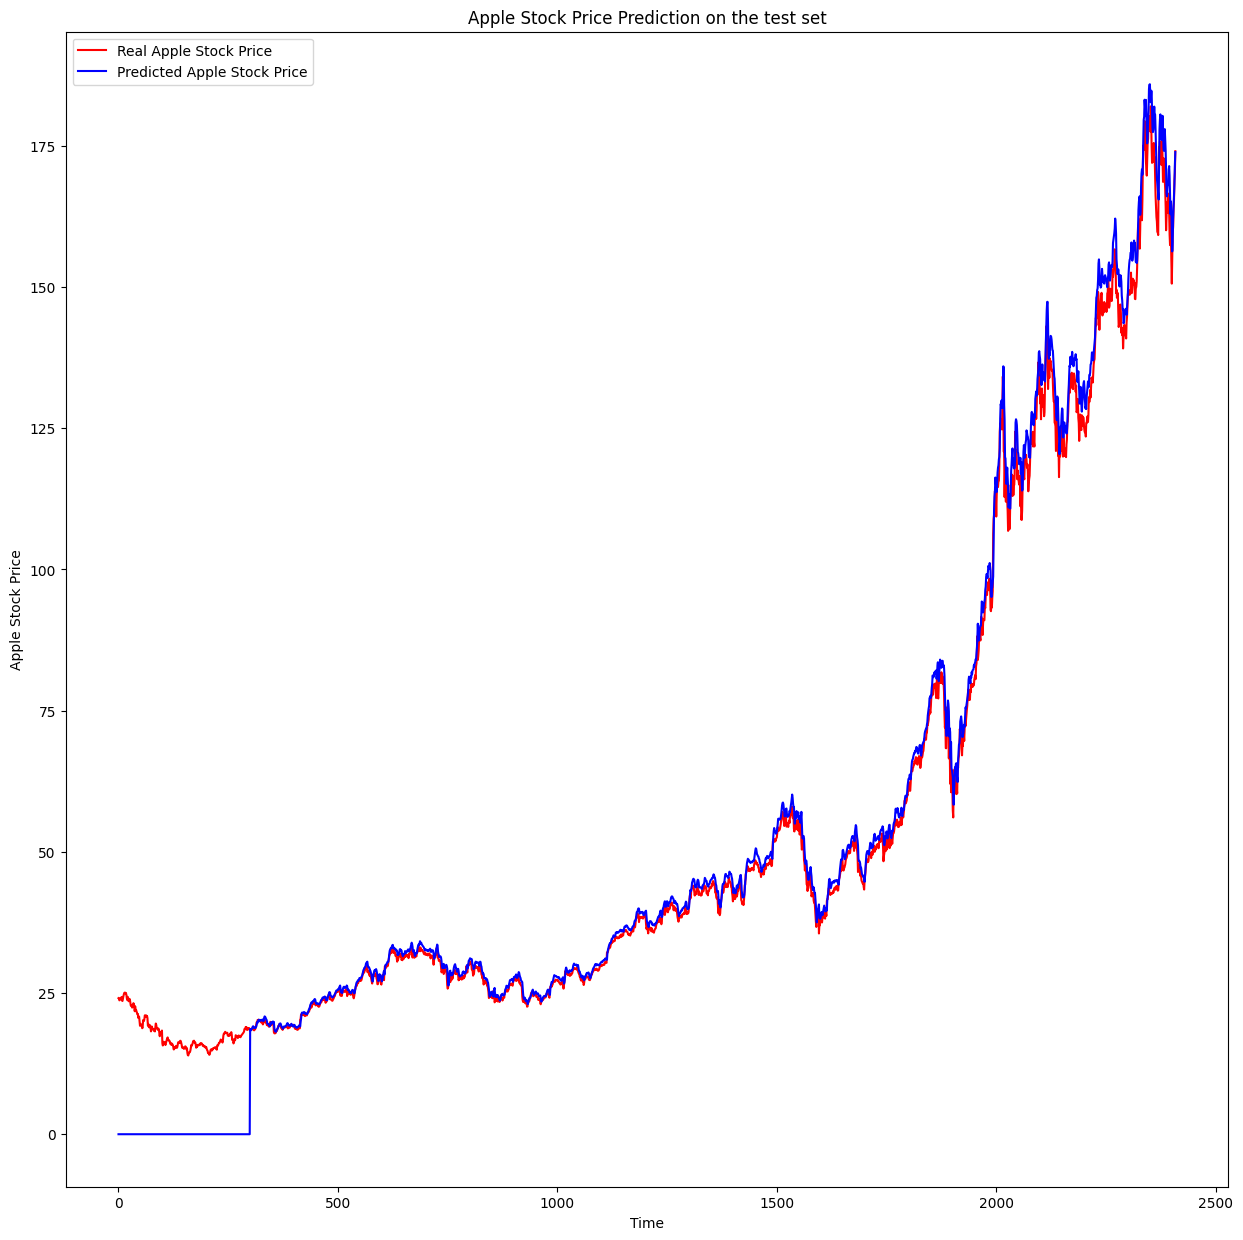

In [57]:
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction_test = np.concatenate((zeros, price_prediction_test), axis=None)
plt.figure(figsize=(15,15))
plt.plot(test_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction_test, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the test set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()